In [ ]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-ocr -q

In [ ]:
import keras_ocr
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
def reorder(df):
  # Then sort based on the y-coordinate (bbox[0][1]) in increasing order
  df['y_coordinate'] = df['bbox'].apply(lambda x: x[0][1])
  df = df.sort_values(by='y_coordinate').reset_index(drop=True)
  df.drop(columns='y_coordinate', inplace=True)

  y_threshold = 5  # Adjust this threshold based on your requirements

  # Function to group words based on their y-coordinate
  def group_words_by_y(df, y_threshold):
      groups = []
      curr_group = []

      for index, row in df.iterrows():
          if not curr_group:
              curr_group.append(row)
          else:
              prev_y_max = curr_group[-1]['bbox'][0][1]
              curr_y_min = row['bbox'][0][1]
              if curr_y_min - prev_y_max <= y_threshold:
                  curr_group.append(row)
              else:
                  groups.append(curr_group)
                  curr_group = [row]

      if curr_group:
          groups.append(curr_group)

      return groups

  # Group words based on y-coordinate
  word_groups = group_words_by_y(df, y_threshold)

  # Sort each group based on the x-coordinate (bbox[0][0]) in increasing order
  sorted_word_groups = []
  for group in word_groups:
      sorted_group = sorted(group, key=lambda x: x['bbox'][0][0])
      sorted_word_groups.append(sorted_group)

  # Flatten the list of groups
  flattened_groups = [item for sublist in sorted_word_groups for item in sublist]

  # Create a new DataFrame with sorted words
  sorted_df = pd.DataFrame(flattened_groups)
  return sorted_df



#main grouping in sentences
def group(sorted_df):
  x_threshold = 20  # Adjust this threshold based on your requirements
  y_threshold = 5   # Adjust this threshold based on your requirements

  # Initialize variables to store merged records
  merged_records = []

  # Initialize variable to store the current merged record
  merged_record = None

  # Iterate through the DataFrame
  for index, row in sorted_df.iterrows():
      if merged_record is None:
          merged_record = row
      else:
          prev_bbox = merged_record['bbox']
          curr_bbox = row['bbox']

          # Calculate the x-coordinate difference between current and previous bounding boxes
          x_diff = curr_bbox[0][0] - prev_bbox[1][0]
          y_diff = abs(curr_bbox[0][1] - prev_bbox[0][1])

          if x_diff < x_threshold and y_diff < y_threshold:
              # Merge texts and create a new bounding box
              merged_text = merged_record['text'] + " " + row['text']
              merged_bbox = [prev_bbox[0], curr_bbox[1], prev_bbox[2], curr_bbox[3]]

              # Update the current merged record
              merged_record = {'text': merged_text, 'bbox': merged_bbox}
          else:
              # If x-coordinate difference exceeds the threshold, append the previous merged record
              # and update the current merged record with the new row
              merged_records.append(merged_record)
              merged_record = row

  # Append the last merged record
  if merged_record is not None:
      merged_records.append(merged_record)

  # Create a new DataFrame with merged records
  merged_df = pd.DataFrame(merged_records)
  return merged_df

7/7 [==============================] - 7s 220ms/step


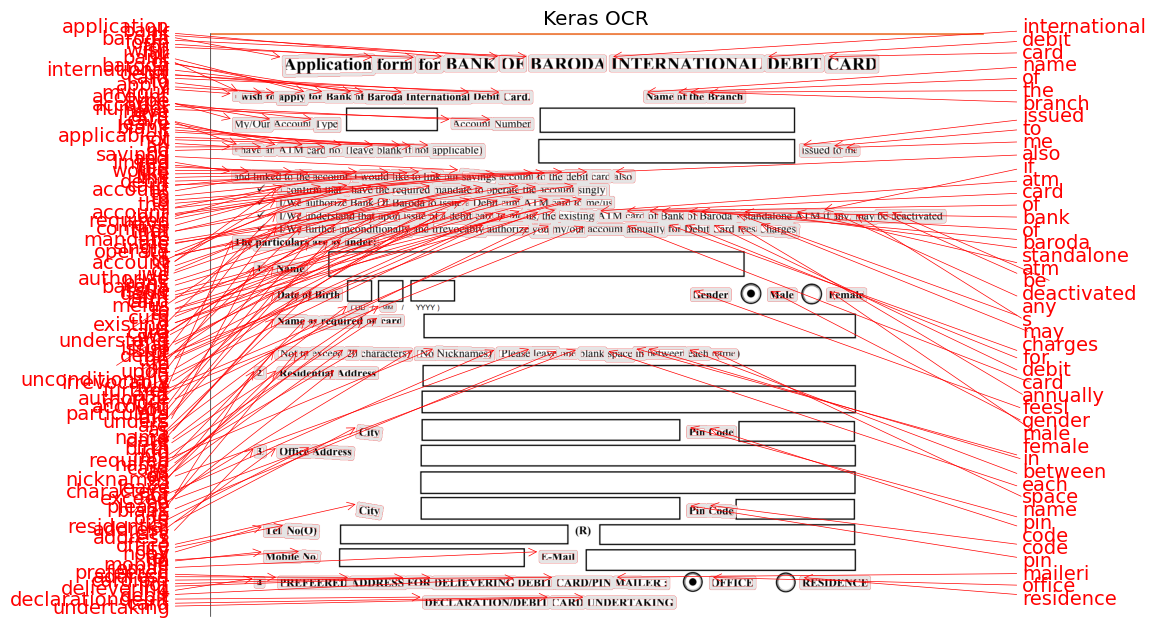

In [ ]:
image_path = "/content/drive/MyDrive/Finance proj/Screenshot 2024-03-22 at 7.47.06 PM.png"
results = pipeline.recognize([image_path])
df = pd.DataFrame(results[0], columns=['text', 'bbox'])
fig, ax = plt.subplots(figsize=(10, 10))
keras_ocr.tools.drawAnnotations(plt.imread(image_path), results[0], ax=ax)
ax.set_title('Keras OCR')
plt.show()

In [ ]:
df.head(10)

,text,bbox
0,application,"[[154.3525, 51.784492], [339.27585, 48.2954], ..."
1,bank,"[[488.10938, 50.0625], [594.4922, 50.0625], [5..."
2,of,"[[603.8789, 50.0625], [653.9414, 50.0625], [65..."
3,baroda,"[[663.3281, 50.0625], [818.209, 50.0625], [818..."
4,international,"[[830.7246, 50.0625], [1145.1797, 50.0625], [1..."
5,debit,"[[1151.4375, 50.0625], [1268.7715, 50.0625], [..."
6,card,"[[1276.5938, 50.0625], [1381.4121, 50.0625], [..."
7,form,"[[344.1797, 51.626953], [422.40234, 51.626953]..."
8,for,"[[430.2246, 51.626953], [481.85156, 51.626953]..."
9,wish,"[[65.70703, 123.5918], [112.640625, 123.5918],..."


In [ ]:
sorted_df = reorder(df)
merged_df = group(sorted_df)

In [ ]:
sorted_df.head(10)

,text,bbox
8,application,"[[154.3525, 51.784492], [339.27585, 48.2954], ..."
6,form,"[[344.1797, 51.626953], [422.40234, 51.626953]..."
7,for,"[[430.2246, 51.626953], [481.85156, 51.626953]..."
0,bank,"[[488.10938, 50.0625], [594.4922, 50.0625], [5..."
1,of,"[[603.8789, 50.0625], [653.9414, 50.0625], [65..."
2,baroda,"[[663.3281, 50.0625], [818.209, 50.0625], [818..."
3,international,"[[830.7246, 50.0625], [1145.1797, 50.0625], [1..."
4,debit,"[[1151.4375, 50.0625], [1268.7715, 50.0625], [..."
5,card,"[[1276.5938, 50.0625], [1381.4121, 50.0625], [..."
23,l,"[[51.626953, 126.7207], [59.44922, 126.7207], ..."


In [ ]:
merged_df.head(100)

,text,bbox
0,application form for bank of baroda internatio...,"[[154.3525, 51.784492], [1381.4121, 50.0625], ..."
1,l wish to apply for bank of baroda internation...,"[[51.626953, 126.7207], [666.45703, 123.5918],..."
2,name of the branch,"[[901.125, 123.5918], [1106.0684, 123.5918], [..."
3,myiour account type,"[[51.626953, 179.91211], [269.08594, 179.91211..."
4,account number,"[[503.7539, 179.91211], [668.0215, 179.91211],..."
5,l have an atm card no leave blank if not appli...,"[[51.626953, 236.23242], [567.8965, 233.10352]..."
6,issued to me,"[[1223.4023, 233.10352], [1342.3008, 237.79688..."
7,and linked to the account l would like to link...,"[[50.0625, 287.85938], [877.6582, 287.85938], ..."
8,l confirm that t have the required mandate to ...,"[[145.49414, 319.14844], [824.4668, 316.01953]..."
9,iwe authorize bank of baroda to issue a debit ...,"[[143.92969, 342.61523], [835.41797, 342.61523..."


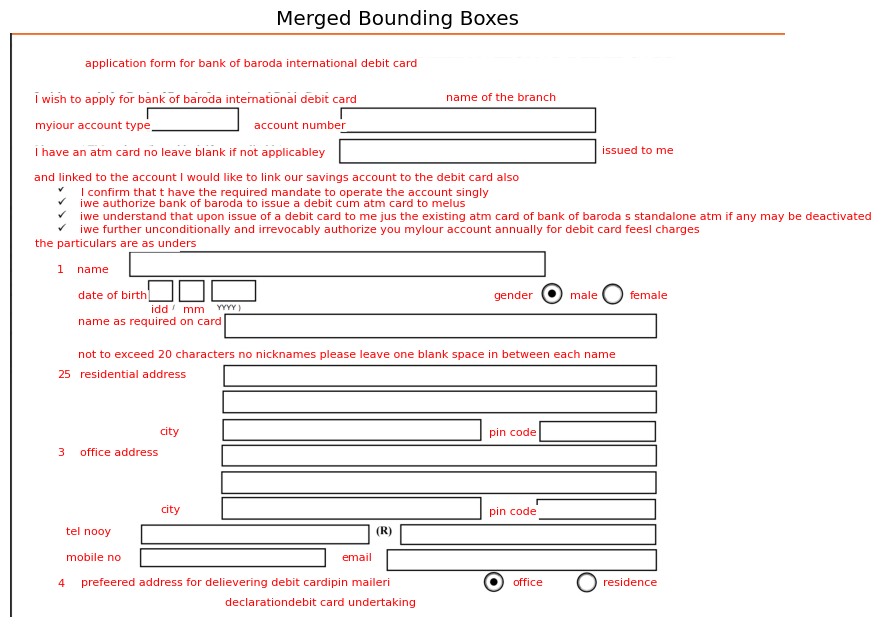

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(image_path, merged_df):
    # Read the image
    image = plt.imread(image_path)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the image
    ax.imshow(image)

    # Iterate over each row in merged_df and draw bounding box
    for index, row in merged_df.iterrows():
        bbox = row['bbox']
        x_min, y_min = bbox[0][0], bbox[0][1]
        width = bbox[1][0] - bbox[0][0]
        height = bbox[2][1] - bbox[0][1]

        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height+5, linewidth=2, edgecolor='white', facecolor='white')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add text label with white background and red text
        ax.text(x_min, y_min, row['text'], color='red', fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='white', alpha=1, pad=0.5))

    ax.set_title('Merged Bounding Boxes')
    plt.axis('off')  # Hide axis
    plt.show()

# Assuming image_path contains the path to your image and merged_df is your merged DataFrame
draw_bounding_boxes(image_path, merged_df)


In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator
def translate_to_hindi(text):
  print(text)
  if text != "tel nooy":
    translator = Translator()
    translated_text = translator.translate(text, dest='hi')
    return translated_text.text
  else:
    return ""

# Apply translation function to each record in the 'text' column
merged_df['text_hindi'] = merged_df['text'].apply(translate_to_hindi)

# Create a new DataFrame with translated text
translated_df = merged_df[['text_hindi']]
merged_df.head(10)

application form for bank of baroda international debit card
l wish to apply for bank of baroda international debit card
name of the branch
myiour account type
account number
l have an atm card no leave blank if not applicabley
issued to me
and linked to the account l would like to link our savings account to the debit card also
l confirm that t have the required mandate to operate the account singly
iwe authorize bank of baroda to issue a debit cum atm card to melus
iwe understand that upon issue of a debit card to me jus the existing atm card of bank of baroda s standalone atm if any may be deactivated
iwe further unconditionally and irrevocably authorize you mylour account annually for debit card feesl charges
the particulars are as unders
1
name
date of birth
gender
male
female
idd
mm
name as required on card
not to exceed 20 characters no nicknames please leave one blank space in between each name
25
residential address
city
pin code
3
office address
city
pin code
tel nooy
mobile 

,text,bbox,text_hindi
0,application form for bank of baroda internatio...,"[[154.3525, 51.784492], [1381.4121, 50.0625], ...",बैंक ऑफ बड़ौदा अंतर्राष्ट्रीय डेबिट कार्ड के ल...
1,l wish to apply for bank of baroda internation...,"[[51.626953, 126.7207], [666.45703, 123.5918],...",l बैंक ऑफ बड़ौदा अंतर्राष्ट्रीय डेबिट कार्ड के...
2,name of the branch,"[[901.125, 123.5918], [1106.0684, 123.5918], [...",शाखा का नाम
3,myiour account type,"[[51.626953, 179.91211], [269.08594, 179.91211...",myiour खाता प्रकार
4,account number,"[[503.7539, 179.91211], [668.0215, 179.91211],...",खाता संख्या
5,l have an atm card no leave blank if not appli...,"[[51.626953, 236.23242], [567.8965, 233.10352]...",एल के पास एक एटीएम कार्ड नहीं है अगर लागू नहीं...
6,issued to me,"[[1223.4023, 233.10352], [1342.3008, 237.79688...",मुझे जारी किया गया
7,and linked to the account l would like to link...,"[[50.0625, 287.85938], [877.6582, 287.85938], ...",और खाता से जुड़ा l हमारे बचत खाते को डेबिट कार...
8,l confirm that t have the required mandate to ...,"[[145.49414, 319.14844], [824.4668, 316.01953]...",l पुष्टि करते हैं कि t को अकेले खाते को संचालि...
9,iwe authorize bank of baroda to issue a debit ...,"[[143.92969, 342.61523], [835.41797, 342.61523...",Iwe मेलस के लिए डेबिट सह एटीएम कार्ड जारी करने...


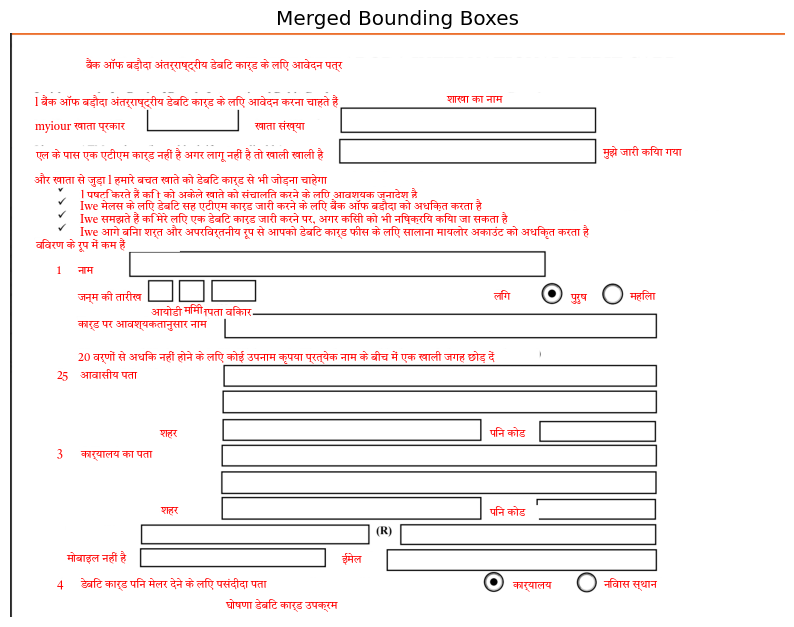

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm  # Import font manager

def draw_bounding_boxes(image_path, merged_df):
    # Read the image
    image = plt.imread(image_path)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the image
    ax.imshow(image)
    hindi_font_path = '/content/drive/MyDrive/Finance proj/hindi.ttf'  # Replace with the path to your Hindi font file
    hindi_font_prop = fm.FontProperties(fname=hindi_font_path)


    # Iterate over each row in merged_df and draw bounding box
    for index, row in merged_df.iterrows():
        bbox = row['bbox']
        x_min, y_min = bbox[0][0], bbox[0][1]
        width = bbox[1][0] - bbox[0][0]
        height = bbox[2][1] - bbox[0][1]

        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height+5, linewidth=2, edgecolor='white', facecolor='white')

        # Add the patch to the Axes
        ax.add_patch(rect)
        # Add text label with white background and red text
        ax.text(x_min, y_min, row['text_hindi'], color='red', fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='white', alpha=1, pad=0.5), fontproperties=hindi_font_prop)

    ax.set_title('Merged Bounding Boxes')
    plt.axis('off')  # Hide axis
    plt.show()

# Assuming image_path contains the path to your image and merged_df is your merged DataFrame
draw_bounding_boxes(image_path, merged_df)

In [ ]:
from googletrans import Translator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm  # Import font manager

In [ ]:
def form_translate(image_path, lang):
  def reorder(df):
    # Then sort based on the y-coordinate (bbox[0][1]) in increasing order
    df['y_coordinate'] = df['bbox'].apply(lambda x: x[0][1])
    df = df.sort_values(by='y_coordinate').reset_index(drop=True)
    df.drop(columns='y_coordinate', inplace=True)

    y_threshold = 5  # Adjust this threshold based on your requirements

    # Function to group words based on their y-coordinate
    def group_words_by_y(df, y_threshold):
        groups = []
        curr_group = []

        for index, row in df.iterrows():
            if not curr_group:
                curr_group.append(row)
            else:
                prev_y_max = curr_group[-1]['bbox'][0][1]
                curr_y_min = row['bbox'][0][1]
                if curr_y_min - prev_y_max <= y_threshold:
                    curr_group.append(row)
                else:
                    groups.append(curr_group)
                    curr_group = [row]

        if curr_group:
            groups.append(curr_group)

        return groups

    # Group words based on y-coordinate
    word_groups = group_words_by_y(df, y_threshold)

    # Sort each group based on the x-coordinate (bbox[0][0]) in increasing order
    sorted_word_groups = []
    for group in word_groups:
        sorted_group = sorted(group, key=lambda x: x['bbox'][0][0])
        sorted_word_groups.append(sorted_group)

    # Flatten the list of groups
    flattened_groups = [item for sublist in sorted_word_groups for item in sublist]

    # Create a new DataFrame with sorted words
    sorted_df = pd.DataFrame(flattened_groups)
    return sorted_df



  #main grouping in sentences
  def group(sorted_df):
    x_threshold = 20  # Adjust this threshold based on your requirements
    y_threshold = 5   # Adjust this threshold based on your requirements

    # Initialize variables to store merged records
    merged_records = []

    # Initialize variable to store the current merged record
    merged_record = None

    # Iterate through the DataFrame
    for index, row in sorted_df.iterrows():
        if merged_record is None:
            merged_record = row
        else:
            prev_bbox = merged_record['bbox']
            curr_bbox = row['bbox']

            # Calculate the x-coordinate difference between current and previous bounding boxes
            x_diff = curr_bbox[0][0] - prev_bbox[1][0]
            y_diff = abs(curr_bbox[0][1] - prev_bbox[0][1])

            if x_diff < x_threshold and y_diff < y_threshold:
                # Merge texts and create a new bounding box
                merged_text = merged_record['text'] + " " + row['text']
                merged_bbox = [prev_bbox[0], curr_bbox[1], prev_bbox[2], curr_bbox[3]]

                # Update the current merged record
                merged_record = {'text': merged_text, 'bbox': merged_bbox}
            else:
                # If x-coordinate difference exceeds the threshold, append the previous merged record
                # and update the current merged record with the new row
                merged_records.append(merged_record)
                merged_record = row

    # Append the last merged record
    if merged_record is not None:
        merged_records.append(merged_record)

    # Create a new DataFrame with merged records
    merged_df = pd.DataFrame(merged_records)
    return merged_df

  def translate_to_x(text):
      translator = Translator()
      translated_text = translator.translate(text, dest=lang)
      return translated_text.text

  def get_font_path(lang):
    font_paths = {
    'hi': '/content/drive/MyDrive/Finance proj/hindi.ttf',
    'bn': '/content/drive/MyDrive/Finance proj/bengali.ttf',
    'te': '/content/drive/MyDrive/Finance proj/telugu.ttf',
    'mr': '/content/drive/MyDrive/Finance proj/marathi.ttf',
    'ta': '/content/drive/MyDrive/Finance proj/tamil.ttf',
    'gu': '/content/drive/MyDrive/Finance proj/gujarati.ttf',
    'kn': '/content/drive/MyDrive/Finance proj/kannada.ttf',
    'ml': '/content/drive/MyDrive/Finance proj/malayalam.ttf'
    }
    return font_paths[lang]

  def draw_bounding_boxes(image_path, merged_df):
      # Read the image
      image = plt.imread(image_path)

      # Create figure and axes
      fig, ax = plt.subplots(figsize=(10, 10))

      # Display the image
      ax.imshow(image)
      x_font_path = get_font_path(lang)  # Replace with the path to your Hindi font file
      x_font_prop = fm.FontProperties(fname=x_font_path)


      # Iterate over each row in merged_df and draw bounding box
      for index, row in merged_df.iterrows():
          bbox = row['bbox']
          x_min, y_min = bbox[0][0], bbox[0][1]
          width = bbox[1][0] - bbox[0][0]
          height = bbox[2][1] - bbox[0][1]

          # Create a Rectangle patch
          rect = patches.Rectangle((x_min, y_min), width, height+5, linewidth=2, edgecolor='white', facecolor='white')

          # Add the patch to the Axes
          ax.add_patch(rect)
          # Add text label with white background and red text
          ax.text(x_min, y_min, row['text_x'], color='red', fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='white', alpha=1, pad=0.5), fontproperties=x_font_prop)

      ax.set_title('Merged Bounding Boxes')
      plt.axis('off')  # Hide axis
      plt.show()


  results = pipeline.recognize([image_path])
  df = pd.DataFrame(results[0], columns=['text', 'bbox'])
  fig, ax = plt.subplots(figsize=(10, 10))
  keras_ocr.tools.drawAnnotations(plt.imread(image_path), results[0], ax=ax)
  ax.set_title('Keras OCR')
  plt.show()
  df = df[df['text'] != 'e']
  sorted_df = reorder(df)
  merged_df = group(sorted_df)
  # Apply translation function to each record in the 'text' column
  merged_df['text_x'] = merged_df['text'].apply(translate_to_x)
  # Create a new DataFrame with translated text
  translated_df = merged_df[['text_x']]
  # Assuming image_path contains the path to your image and merged_df is your merged DataFrame
  draw_bounding_boxes(image_path, merged_df)
  ax.set_title('Merged Bounding Boxes')
  plt.axis('off')  # Hide axis
  # Save the final image
  plt.savefig('/content/drive/MyDrive/Finance proj/form2_update.png', bbox_inches='tight')
  plt.close()


2/2 [==============================] - 3s 3s/step


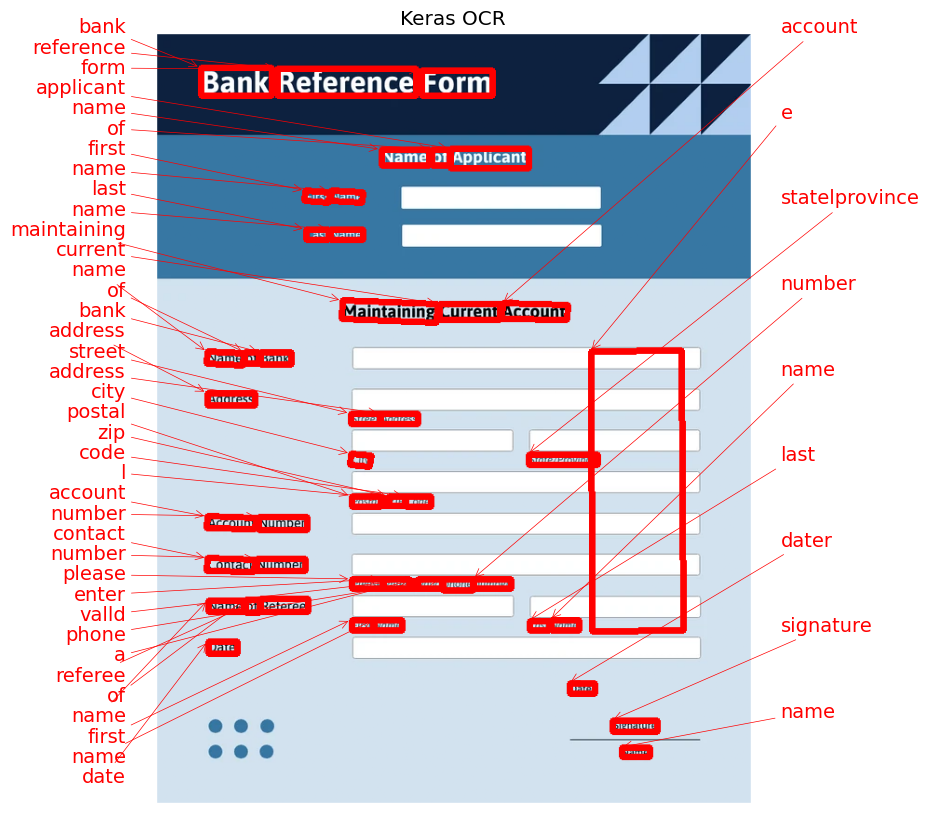

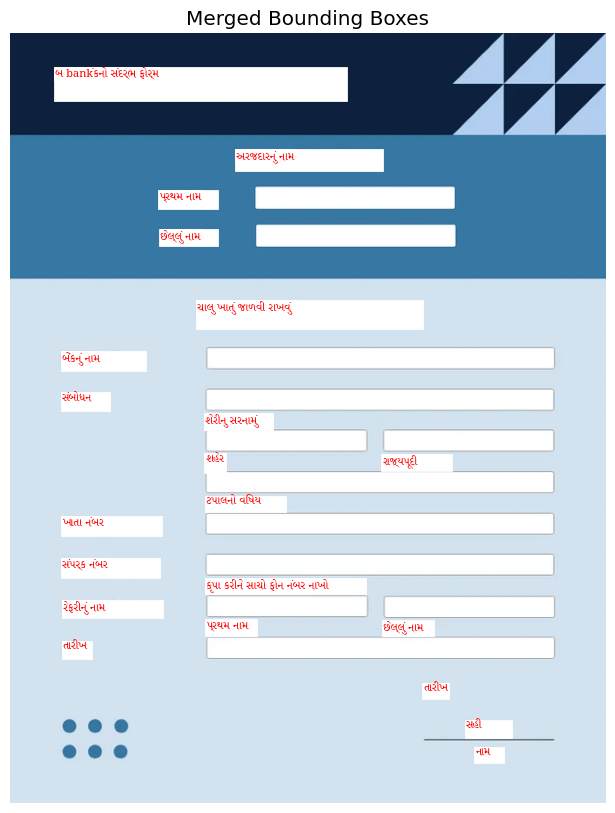

In [ ]:
image_p = '/content/drive/MyDrive/Finance proj/form2.jpg'
merged_df = form_translate(image_p, 'gu')

12/12 [==============================] - 4s 331ms/step


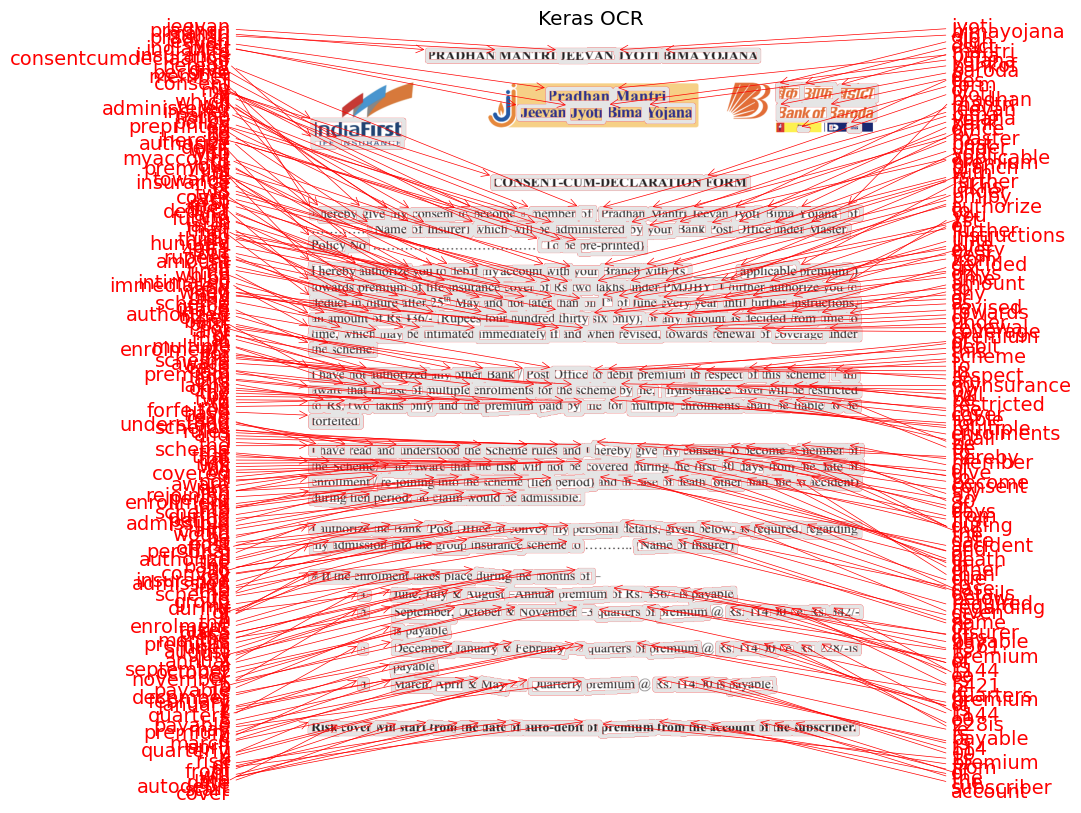

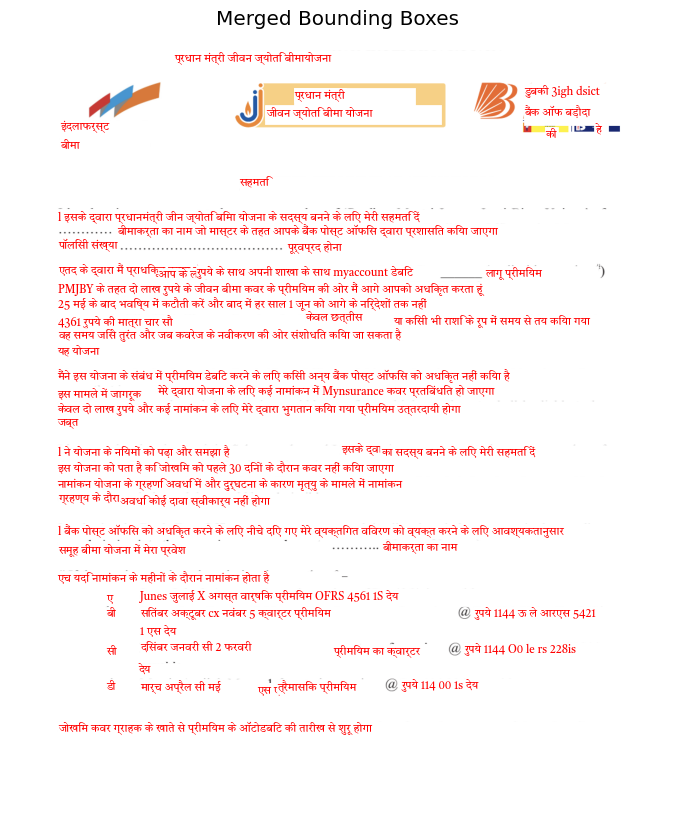

In [ ]:
image_p2 = '/content/drive/MyDrive/Finance proj/form3.png'
form_translate(image_p2, 'hi')